# get sparse transform.json information

In [1]:
import torch
import numpy as np

In [2]:
import json
from PIL import Image

json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# json_dir = 'datasets/tea_pot_transform_mode/transforms_train.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)

# 打印数据
frames_dict = data['frames']

# 将frames_dict中包含的file_path的图像复制到新文件夹中
import os
import shutil

new_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images_colmap_sparsed'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
for frame_id in frames_dict:
    
    file_path = frame_id['file_path'] # 这是路径
    if os.path.exists(file_path):
        shutil.copy(file_path, new_dir)

In [3]:
frames_data = data['frames']
frames_data[0]['transform_matrix'], frames_data[0]['R'], frames_data[0]['t']

([[-0.9727637065583954,
   -0.07190122871036342,
   -0.22036557026146,
   -1.083079321790976],
  [-0.1645109555045292,
   -0.455592593601138,
   0.8748551503964206,
   3.9095334432312985],
  [-0.16330008195290488,
   0.8872798893253386,
   0.43135540019490454,
   2.111893505221585],
  [0.0, 0.0, 0.0, 1.0]],
 [[-0.08596428877222426, -0.11611540463617656, 0.9895086426414188],
  [0.5258625811102863, 0.8382821329562862, 0.14405419589268126],
  [-0.846214326777746, 0.5327290853449211, -0.011001580961405244]],
 [[-1.5057532745816946], [-1.0842134936207521], [4.074468839064363]])

In [4]:
#合并frames_data[0]['R'], frames_data[0]['t']为pytorch格式
R_list = []
t_list = []
transform_matrix_list = []
image_list = []

for frame in frames_data:
    R = frame['R']
    t = frame['t']
    transform_matrix = frame['transform_matrix']
    image_path = frame['file_path']
    image_pil = Image.open(image_path)
    
    
    R_list.append(R)
    t_list.append(t)
    transform_matrix_list.append(transform_matrix)
    image_list.append(image_pil)
R_array = np.stack(R_list)
t_array = np.stack(t_list)
transform_matrix_array = np.stack(transform_matrix_list)
image_array = np.stack(image_list)
# R_torch = torch.stack(torch.from_numpy(R_array), dim=0)
# t_torch = torch.stack(torch.from_numpy(t_array), dim=0)
R_torch = torch.from_numpy(R_array)
t_torch = torch.from_numpy(t_array).squeeze(2)
transform_matrix_torch = torch.from_numpy(transform_matrix_array)
image_torch = torch.from_numpy(image_array)

In [5]:
transform_matrix_array.shape

(54, 4, 4)

# 原始点云展示

In [6]:
# 简单的例子，展示如何使用open3d的create_camera_visualization函数来生成相机的可视化线段. 
# 这里我hardcode了一组随机的相机参数。
import open3d as o3d
import numpy as np
import json

WIDTH = 1920
HEIGHT = 1080


json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)
frames_data = data['frames']
# print(data['h'])
intrinsics = np.array([
    [data['fl_x'], 0,            data['cx'], 0],
    [0,            data['fl_y'], data['cy'], 0],
    [0,            0,            1,          0],
    [0,            0,            0,          1]
])

# load a scene point cloud
scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
# scene = o3d.io.read_triangle_mesh('/home/ubunto/Project/konglx/pcd/image_to_3d/TRELLIS/trellis-outputs/tea-pot_letter/sample.glb')
# 可视化坐标轴. The x, y, z axis will be rendered as red, green, and blue arrows respectively.
coor = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])   
vizualizer = o3d.visualization.Visualizer()
vizualizer.create_window(width=WIDTH, height=HEIGHT)


for frame in frames_data:
    R = np.array(frame['R'])
    t = np.array(frame['t'])
    # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
    top = np.hstack([R, t.reshape(3, 1)])  # 3x4

    # 创建最后一行 [0,0,0,1]
    bottom = np.array([[0, 0, 0, 1]])

    # 垂直拼接生成 4x4 矩阵
    extrinsics = np.vstack([top, bottom])

    # core code. Set up a set of lines to represent the camera.
    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=int(data['w']), view_height_px=int(data['h']), 
                                                                   intrinsic=intrinsics[:3,:3], extrinsic=extrinsics,
                                                                   scale=0.5)
    
    vizualizer.add_geometry(cameraLines)
    # vizualizer.add_geometry(scene)
    # vizualizer.add_geometry(coor)
vizualizer.add_geometry(scene)
vizualizer.add_geometry(coor)
vizualizer.run()
vizualizer.destroy_window()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
dir(scene), scene.covariances, scene.points, scene.normals

(['HalfEdgeTriangleMesh',
  'Image',
  'LineSet',
  'PointCloud',
  'RGBDImage',
  'TetraMesh',
  'TriangleMesh',
  'Type',
  'Unspecified',
  'VoxelGrid',
  '__add__',
  '__class__',
  '__copy__',
  '__deepcopy__',
  '__delattr__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__gt__',
  '__hash__',
  '__iadd__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  'clear',
  'cluster_dbscan',
  'colors',
  'compute_convex_hull',
  'compute_mahalanobis_distance',
  'compute_mean_and_covariance',
  'compute_nearest_neighbor_distance',
  'compute_point_cloud_distance',
  'covariances',
  'create_from_depth_image',
  'create_from_rgbd_image',
  'crop',
  'detect_planar_patches',
  'dimension',
  'estimate_covariances',
  'estimate_normals',
  'estimate_point_covariances',
  'far

In [8]:
scene_colors = np.asarray(scene.colors)
scene_colors.shape, scene_colors.min(), scene_colors.max()

((12785, 3), 0.0, 1.0)

In [9]:
scene_points = np.asarray(scene.points)
scene_points.shape, type(scene_points), scene_points.min(), scene_points.max()  

((12785, 3), numpy.ndarray, -85.1568374633789, 39.379817962646484)

# 添加面积和投影

## 找image_54_1080.jpg找一块方形的区域，绘制，并投影到3d

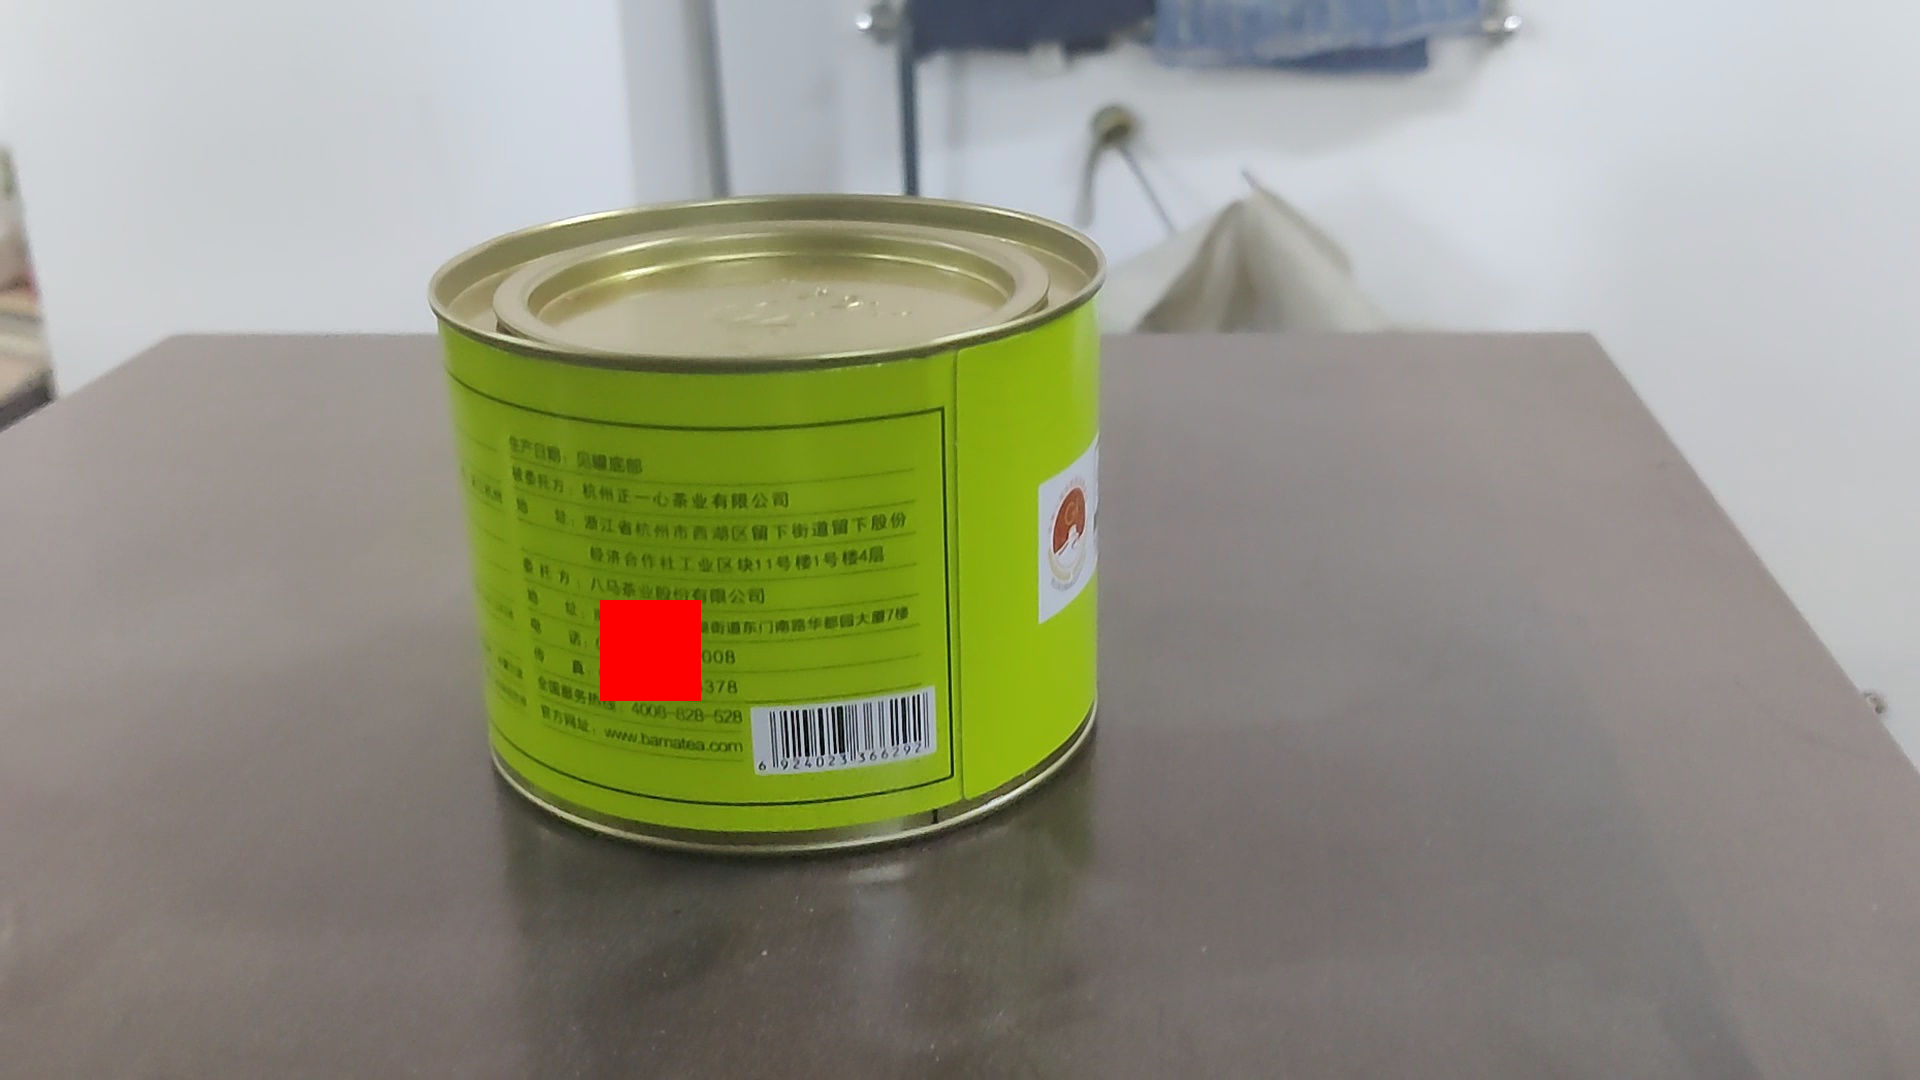

In [1]:
from PIL import Image, ImageDraw

add_xy1 = [600, 600]
add_xy2 = [700, 700]

img_dir = '/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images/image_54_1080（复件）.jpg'
# 在图片上绘制一块矩形红色区域
im = Image.open(img_dir)
draw = ImageDraw.Draw(im)
draw.rectangle((add_xy1[0], add_xy1[1], add_xy2[0], add_xy2[1]), fill='red', outline='red')
im

## 绘制选定区域

In [2]:
import json
from PIL import Image
import open3d as o3d

json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# json_dir = 'datasets/tea_pot_transform_mode/transforms_train.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)

# 打印数据
frames_dict = data['frames']

# 将frames_dict中包含的file_path的图像复制到新文件夹中
import os
import shutil

new_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images_colmap_sparsed'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
for frame_id in frames_dict:
    
    file_path = frame_id['file_path'] # 这是路径
    if os.path.exists(file_path):
        shutil.copy(file_path, new_dir)


frames_data = data['frames']

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [13]:
# load a scene point cloud
scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
scene_points = np.asarray(scene.points)
scene_colors = np.asarray(scene.colors)

In [14]:
import numpy as np
import open3d
## 原始点云 ##
pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(scene_points)

# pcd.colors = open3d.utility.Vector3dVector(colors)
intrinsics = np.array([
    [data['fl_x'], 0,            data['cx'], 0],
    [0,            data['fl_y'], data['cy'], 0],
    [0,            0,            1,          0],
    [0,            0,            0,          1]
])

###########################################
# 增加红色的新点云
# 生成网格点（注意 y 在前，x 在后，与图像的行列索引一致）---->2D网格点
y_range = slice(add_xy1[0], add_xy2[0])  # y 对应行索引
x_range = slice(add_xy1[1], add_xy2[1])  # x 对应列索引
# print(x_range)
# 生成网格点矩阵
y, x = np.mgrid[y_range, x_range]
print(x.shape)
print(y.shape)
# 组合为二维坐标点，并调整形状为 [30000, 2]
selected_area_np = np.column_stack((x.ravel(), y.ravel()))
selected_area_np_qici = np.hstack((selected_area_np, np.ones((selected_area_np.shape[0], 1))))
print(selected_area_np_qici.shape)
# 内参重复10000次，shape为[10000, 4, 4]
intrinsics_area = np.tile(intrinsics, (selected_area_np_qici.shape[0], 1, 1))
print(intrinsics_area.shape)

# 找外参数矩阵
selected_image_name = 'image_54_1080'
for frame in frames_data:
    if selected_image_name in frame['file_path']:
        R = np.array(frame['R'])
        t = np.array(frame['t'])
        # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
        top = np.hstack([R, t.reshape(3, 1)])  # 3x4

        # 创建最后一行 [0,0,0,1]
        bottom = np.array([[0, 0, 0, 1]])

        # 垂直拼接生成 4x4 矩阵
        extrinsics = np.vstack([top, bottom])
    else:
        continue

extrinsics_area = np.tile(extrinsics, (selected_area_np_qici.shape[0], 1, 1))
print(extrinsics_area.shape)

def pixel_to_world(uv, depth, K, R, T):
    # 畸变校正（假设已校正，否则需调用cv2.undistortPoints）
    # 归一化坐标计算
    inv_K = np.linalg.inv(K)
    inv_R = np.linalg.inv(R)
    homogeneous_pixel = uv[..., np.newaxis]
    ndc = inv_K @ homogeneous_pixel  # 归一化坐标（未乘深度）
    # ndc = ndc.squeeze(-1)
    # 应用深度
    camera_coord = ndc * depth
    # camera_coord = ndc
    
    # 转换为世界坐标
    world_coord = (R.transpose(0,2,1) @ camera_coord).squeeze(-1) - \
                    (R.transpose(0,2,1) @ T[..., np.newaxis]).squeeze(-1) 
    return world_coord

world_coords = pixel_to_world(selected_area_np_qici, 1, 
                              intrinsics_area[:,:3, :3], 
                              extrinsics_area[:, :3, :3], 
                              extrinsics_area[:,:3, 3])


# np_rand_dot = np.random.randn(100, 3)
scene_points = np.vstack((scene_points, world_coords))
pcd.points = o3d.utility.Vector3dVector(scene_points)

np_rand_dot_color = np.array([[1, 0, 0]] * world_coords.shape[0])
scene_colors = np.vstack((scene_colors, np_rand_dot_color))
# # 添加原始点云的颜色
# colors = scene_colors
pcd.colors = o3d.utility.Vector3dVector(scene_colors)

###########################################


# o3d.visualization.draw_geometries([pcd])


import open3d as o3d
import numpy as np
import json

WIDTH = 1920
HEIGHT = 1080


json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)
frames_data = data['frames']
# print(data['h'])

# load a scene point cloud
# scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
# scene = o3d.io.read_triangle_mesh('/home/ubunto/Project/konglx/pcd/image_to_3d/TRELLIS/trellis-outputs/tea-pot_letter/sample.glb')
# 可视化坐标轴. The x, y, z axis will be rendered as red, green, and blue arrows respectively.
coor = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])  
# coor.scale(10.0) 
vizualizer = o3d.visualization.Visualizer()
vizualizer.create_window(width=WIDTH, height=HEIGHT)


for frame in frames_data:
    R = np.array(frame['R'])
    t = np.array(frame['t'])
    # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
    top = np.hstack([R, t.reshape(3, 1)])  # 3x4

    # 创建最后一行 [0,0,0,1]
    bottom = np.array([[0, 0, 0, 1]])

    # 垂直拼接生成 4x4 矩阵
    extrinsics = np.vstack([top, bottom])

    # core code. Set up a set of lines to represent the camera.
    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=int(data['w']), view_height_px=int(data['h']), 
                                                                   intrinsic=intrinsics[:3,:3], extrinsic=extrinsics,
                                                                   scale=0.5)
    
    vizualizer.add_geometry(cameraLines)
    # vizualizer.add_geometry(scene)
    # vizualizer.add_geometry(coor)
vizualizer.add_geometry(pcd)
vizualizer.add_geometry(coor)
vizualizer.run()
# 存储点云
o3d.io.write_point_cloud('scene_added_area.ply', pcd)
vizualizer.destroy_window()

(100, 100)
(100, 100)
(10000, 3)
(10000, 4, 4)
(10000, 4, 4)


## 绘制整张图

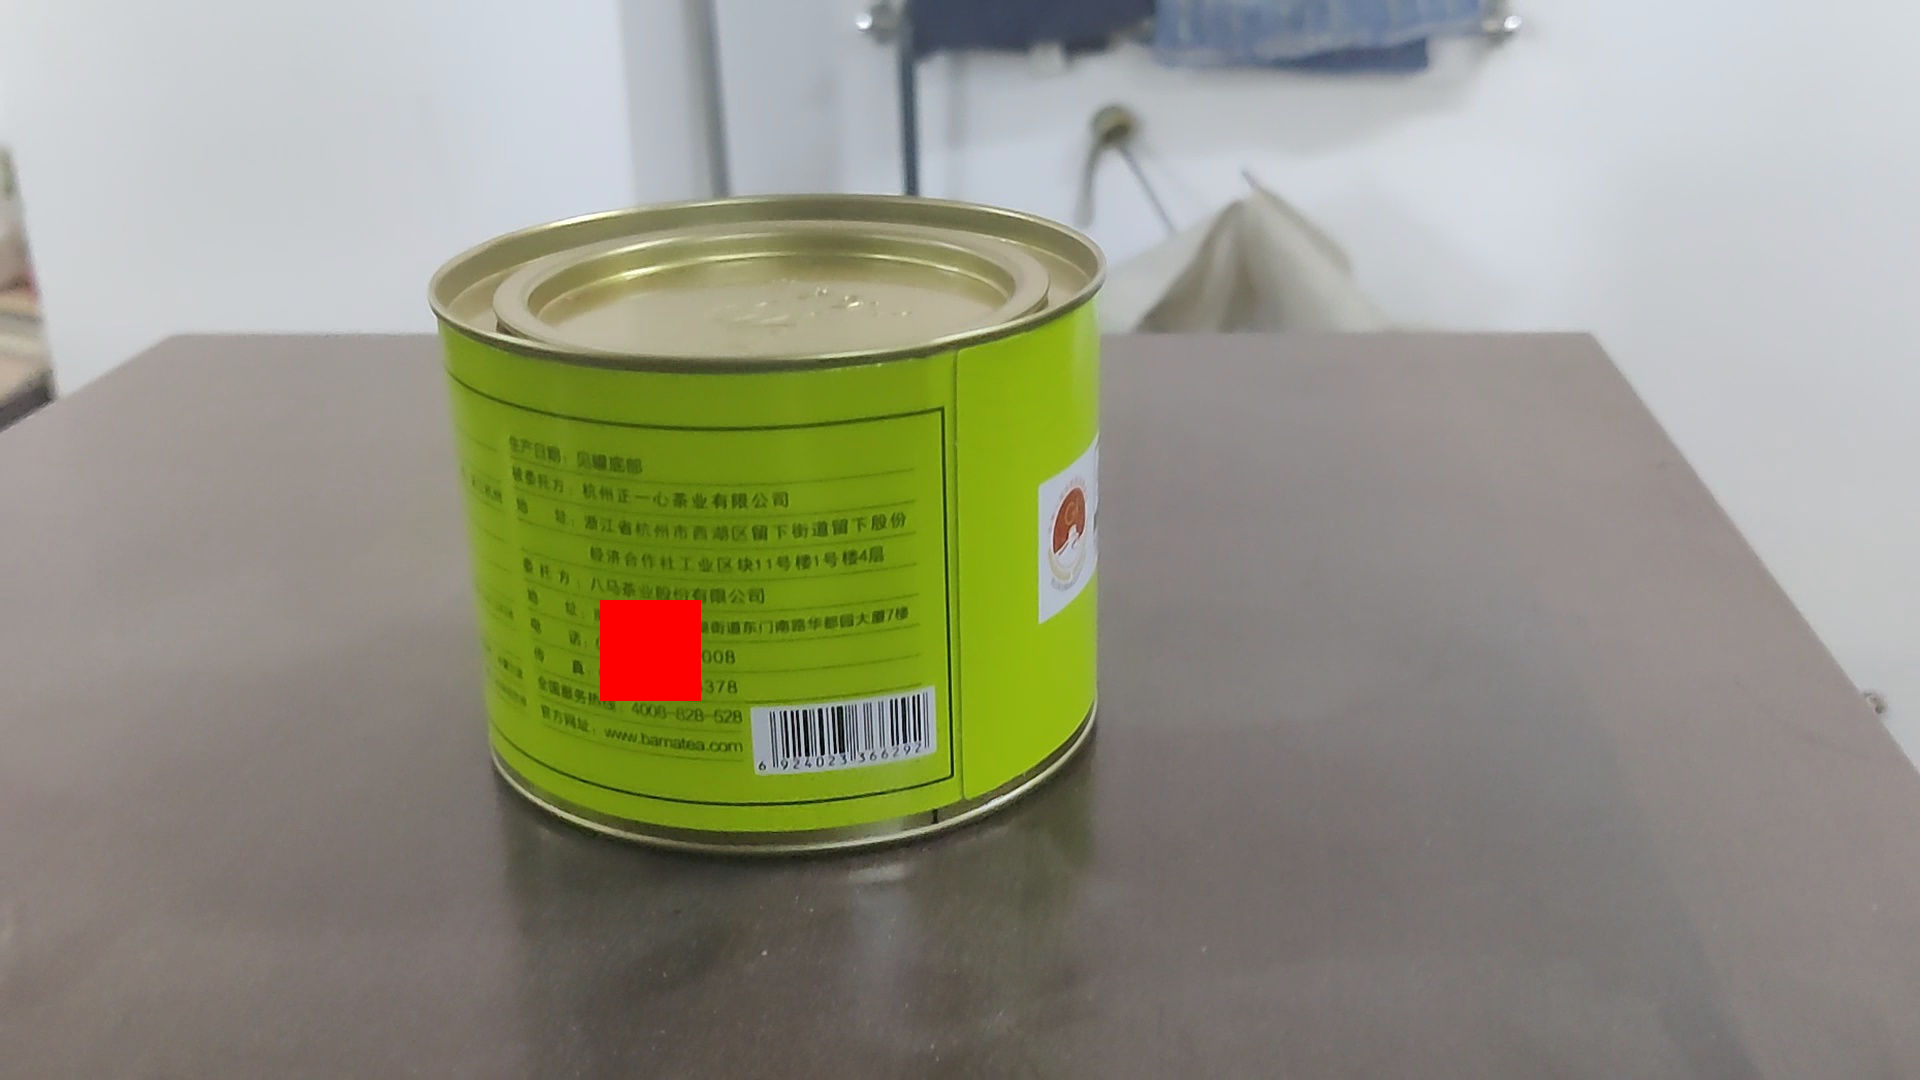

In [1]:
from PIL import Image, ImageDraw

add_xy1 = [600, 600]
add_xy2 = [700, 700]

img_dir = '/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images/image_54_1080（复件）.jpg'
# 在图片上绘制一块矩形红色区域
im = Image.open(img_dir)
draw = ImageDraw.Draw(im)
draw.rectangle((add_xy1[0], add_xy1[1], add_xy2[0], add_xy2[1]), fill='red', outline='red')
im

In [4]:
import json
from PIL import Image
import open3d as o3d
import numpy as np

json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# json_dir = 'datasets/tea_pot_transform_mode/transforms_train.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)

# 打印数据
frames_dict = data['frames']

# 将frames_dict中包含的file_path的图像复制到新文件夹中
import os
import shutil

new_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images_colmap_sparsed'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
for frame_id in frames_dict:
    
    file_path = frame_id['file_path'] # 这是路径
    if os.path.exists(file_path):
        shutil.copy(file_path, new_dir)


frames_data = data['frames']

In [5]:
# load a scene point cloud
scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
scene_points = np.asarray(scene.points)
scene_colors = np.asarray(scene.colors)

In [6]:
img_np = np.asarray(im) / 255.0
img_np.shape, img_np.shape[0]*img_np.shape[1]
img_np_reshape = img_np.reshape(-1, 3)

In [8]:
import numpy as np
import open3d

# 图像的rgb点
img_np = np.asarray(im) / 255.0
img_np.shape, img_np.shape[0]*img_np.shape[1]
img_np_reshape = img_np.reshape(-1, 3)



## 原始点云 ##
pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(scene_points)

# pcd.colors = open3d.utility.Vector3dVector(colors)
intrinsics = np.array([
    [data['fl_x'], 0,            data['cx'], 0],
    [0,            data['fl_y'], data['cy'], 0],
    [0,            0,            1,          0],
    [0,            0,            0,          1]
])

###########################################
# 增加红色的新点云
# 生成网格点（注意 y 在前，x 在后，与图像的行列索引一致）---->2D网格点
y_range = slice(0, im.size[1])  # y 对应行索引
x_range = slice(0, im.size[0])  # x 对应列索引
# print(x_range)
# 生成网格点矩阵
y, x = np.mgrid[y_range, x_range]
print(x.shape)
print(y.shape)
# 组合为二维坐标点，并调整形状为 [30000, 2]
selected_area_np = np.column_stack((x.ravel(), y.ravel()))
selected_area_np_qici = np.hstack((selected_area_np, np.ones((selected_area_np.shape[0], 1))))
print(selected_area_np_qici.shape)
# 内参重复10000次，shape为[10000, 4, 4]
intrinsics_area = np.tile(intrinsics, (selected_area_np_qici.shape[0], 1, 1))
print(intrinsics_area.shape)

# 找外参数矩阵
selected_image_name = 'image_54_1080'
for frame in frames_data:
    if selected_image_name in frame['file_path']:
        R = np.array(frame['R'])
        t = np.array(frame['t'])
        # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
        top = np.hstack([R, t.reshape(3, 1)])  # 3x4

        # 创建最后一行 [0,0,0,1]
        bottom = np.array([[0, 0, 0, 1]])

        # 垂直拼接生成 4x4 矩阵
        extrinsics = np.vstack([top, bottom])
    else:
        continue

extrinsics_area = np.tile(extrinsics, (selected_area_np_qici.shape[0], 1, 1))
print(extrinsics_area.shape)

def pixel_to_world(uv, depth, K, R, T):
    # 畸变校正（假设已校正，否则需调用cv2.undistortPoints）
    # 归一化坐标计算
    inv_K = np.linalg.inv(K)
    inv_R = np.linalg.inv(R)
    homogeneous_pixel = uv[..., np.newaxis]
    ndc = inv_K @ homogeneous_pixel  # 归一化坐标（未乘深度）
    # ndc = ndc.squeeze(-1)
    # 应用深度
    camera_coord = ndc * depth
    # camera_coord = ndc
    
    # 转换为世界坐标
    world_coord = (R.transpose(0,2,1) @ camera_coord).squeeze(-1) - \
                    (R.transpose(0,2,1) @ T[..., np.newaxis]).squeeze(-1) 
    return world_coord

world_coords = pixel_to_world(selected_area_np_qici, 1, 
                              intrinsics_area[:,:3, :3], 
                              extrinsics_area[:, :3, :3], 
                              extrinsics_area[:,:3, 3])


# np_rand_dot = np.random.randn(100, 3)
scene_points = np.vstack((scene_points, world_coords))
pcd.points = open3d.utility.Vector3dVector(scene_points)

# np_rand_dot_color = np.array([[1, 0, 0]] * world_coords.shape[0])
np_rand_dot_color = img_np_reshape
# 添加原始点云的颜色
colors = scene_colors
scene_colors = np.vstack((scene_colors, np_rand_dot_color))
pcd.colors = open3d.utility.Vector3dVector(scene_colors)

###########################################


# o3d.visualization.draw_geometries([pcd])


import open3d as o3d
import numpy as np
import json

WIDTH = 1920
HEIGHT = 1080


json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)
frames_data = data['frames']
# print(data['h'])

# load a scene point cloud
# scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
# scene = o3d.io.read_triangle_mesh('/home/ubunto/Project/konglx/pcd/image_to_3d/TRELLIS/trellis-outputs/tea-pot_letter/sample.glb')
# 可视化坐标轴. The x, y, z axis will be rendered as red, green, and blue arrows respectively.
coor = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])  
# coor.scale(10.0) 
vizualizer = o3d.visualization.Visualizer()
vizualizer.create_window(width=WIDTH, height=HEIGHT)


for frame in frames_data:
    R = np.array(frame['R'])
    t = np.array(frame['t'])
    # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
    top = np.hstack([R, t.reshape(3, 1)])  # 3x4

    # 创建最后一行 [0,0,0,1]
    bottom = np.array([[0, 0, 0, 1]])

    # 垂直拼接生成 4x4 矩阵
    extrinsics = np.vstack([top, bottom])

    # core code. Set up a set of lines to represent the camera.
    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=int(data['w']), view_height_px=int(data['h']), 
                                                                   intrinsic=intrinsics[:3,:3], extrinsic=extrinsics,
                                                                   scale=0.5)
    
    vizualizer.add_geometry(cameraLines)
    # vizualizer.add_geometry(scene)
    # vizualizer.add_geometry(coor)
vizualizer.add_geometry(pcd)
vizualizer.add_geometry(coor)
vizualizer.run()
# 存储点云
o3d.io.write_point_cloud('scene_added_area.ply', pcd)
vizualizer.destroy_window()

(1080, 1920)
(1080, 1920)
(2073600, 3)
(2073600, 4, 4)
(2073600, 4, 4)


# 所有图一起显示

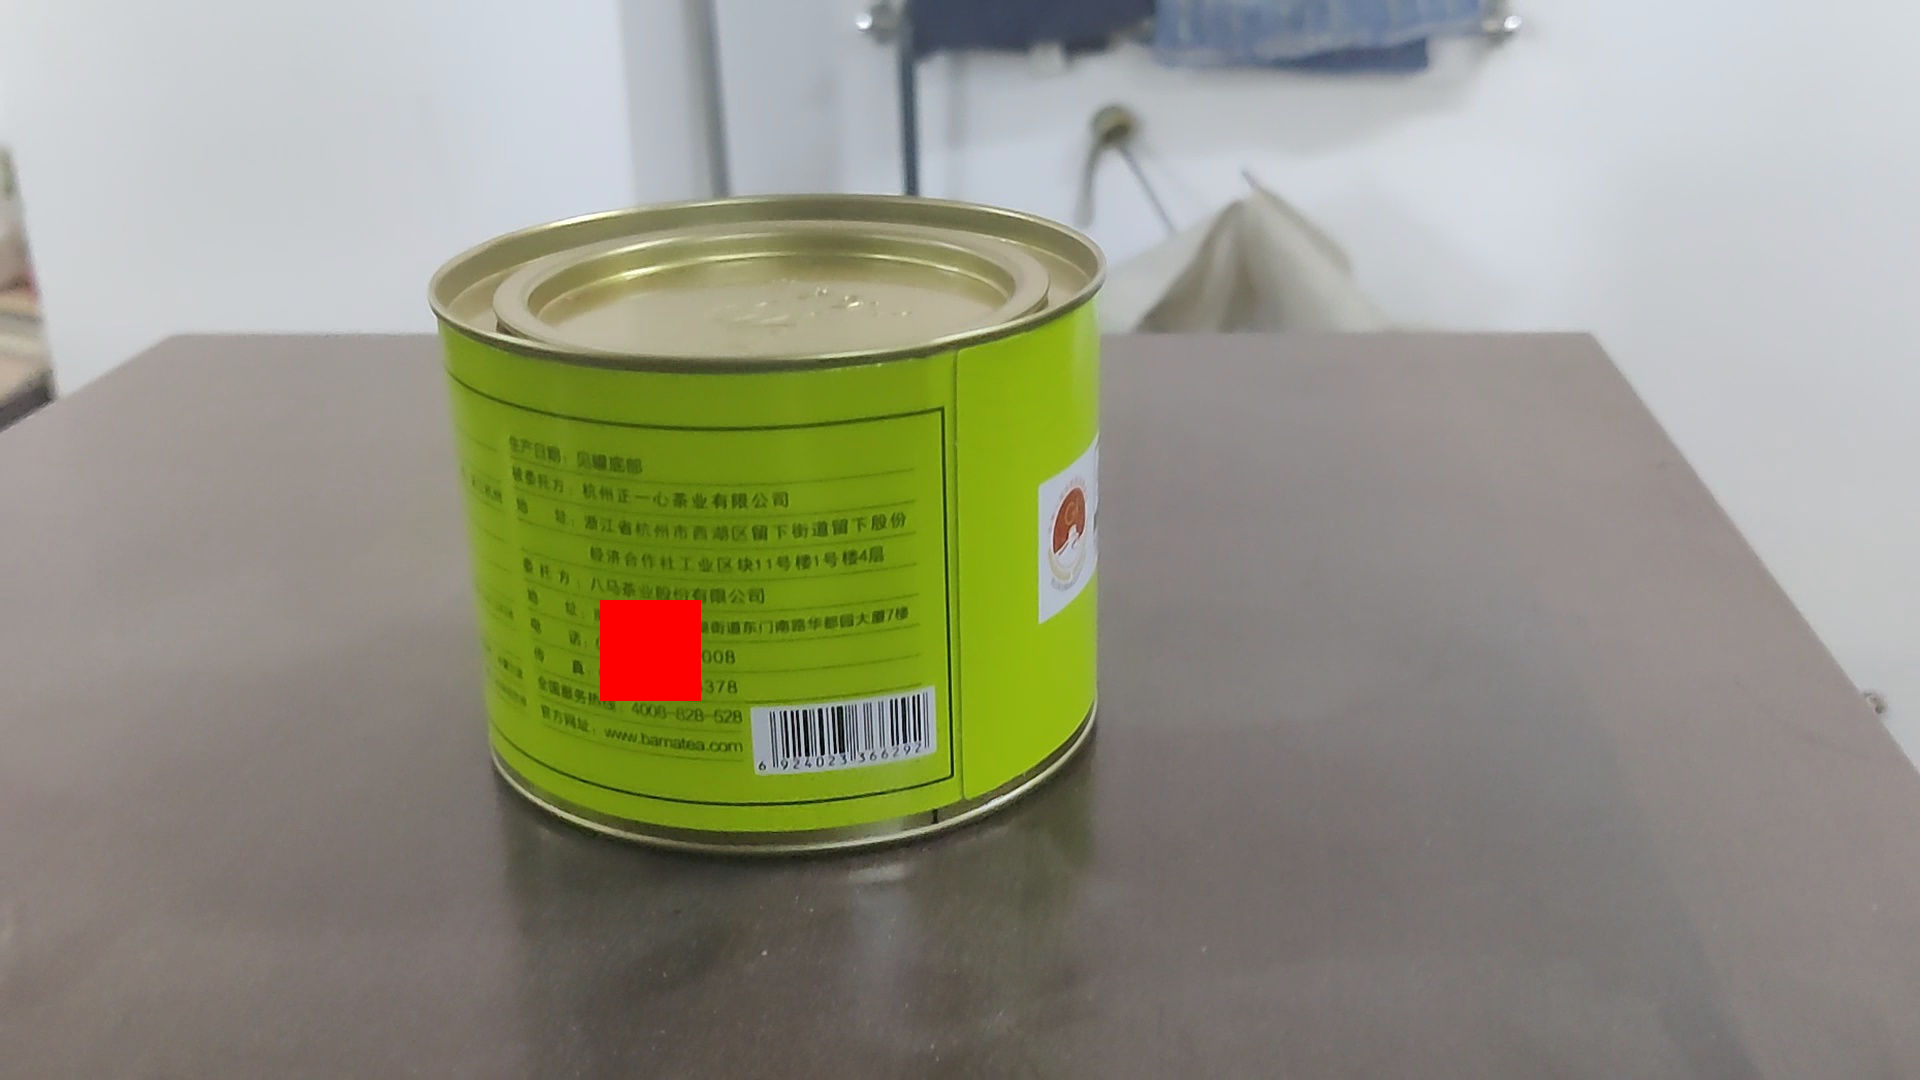

In [1]:
from PIL import Image, ImageDraw

add_xy1 = [600, 600]
add_xy2 = [700, 700]

img_dir = '/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images/image_54_1080（复件）.jpg'
# 在图片上绘制一块矩形红色区域
im = Image.open(img_dir)
draw = ImageDraw.Draw(im)
draw.rectangle((add_xy1[0], add_xy1[1], add_xy2[0], add_xy2[1]), fill='red', outline='red')
im

In [1]:
import json
from PIL import Image
import open3d as o3d
import numpy as np

json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# json_dir = 'datasets/tea_pot_transform_mode/transforms_train.json'
# 读取json文件
with open(json_dir, 'r') as f:
    data = json.load(f)

# 打印数据
frames_dict = data['frames']

# 将frames_dict中包含的file_path的图像复制到新文件夹中
import os
import shutil

new_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images_colmap_sparsed'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
for frame_id in frames_dict:
    
    file_path = frame_id['file_path'] # 这是路径
    if os.path.exists(file_path):
        shutil.copy(file_path, new_dir)


frames_data = data['frames']

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# load a scene point cloud
scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
scene_points = np.asarray(scene.points)
scene_colors = np.asarray(scene.colors)

In [3]:
#合并frames_data[0]['R'], frames_data[0]['t']为pytorch格式
R_list = []
t_list = []
transform_matrix_list = []
path_list = []
image_list = []

for frame in frames_data:
    R = frame['R']
    t = frame['t']
    transform_matrix = frame['transform_matrix']
    image_path = frame['file_path'].split('./')[-1]
    image_pil = Image.open(image_path)
    
    
    R_list.append(R)
    t_list.append(t)
    transform_matrix_list.append(transform_matrix)
    path_list.append(image_path)
    image_list.append(image_pil)


In [4]:
for i in zip(R_list, t_list):
    print(np.asarray(i[0]).shape)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)


In [5]:
from PIL import Image, ImageDraw
import open3d as o3d
import numpy as np
import json



# load a scene point cloud
scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
# scene = o3d.io.read_triangle_mesh('/home/ubunto/Project/konglx/pcd/image_to_3d/TRELLIS/trellis-outputs/tea-pot_letter/sample.glb')
# 可视化坐标轴. The x, y, z axis will be rendered as red, green, and blue arrows respectively.
coor = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])   
vizualizer = o3d.visualization.Visualizer()
WIDTH = 1920
HEIGHT = 1080
vizualizer.create_window(width=WIDTH, height=HEIGHT)


scene_colors = np.asarray(scene.colors)


#########################################################################################
def pixel_to_world(uv, depth, K, R, T):
    # 畸变校正（假设已校正，否则需调用cv2.undistortPoints）
    # 归一化坐标计算
    inv_K = np.linalg.inv(K)
    inv_R = np.linalg.inv(R)
    homogeneous_pixel = uv[..., np.newaxis]
    ndc = inv_K @ homogeneous_pixel  # 归一化坐标（未乘深度）
    # ndc = ndc.squeeze(-1)
    # 应用深度
    camera_coord = ndc * depth
    # camera_coord = ndc
    
    # 转换为世界坐标
    world_coord = (R.transpose(0,2,1) @ camera_coord).squeeze(-1) - \
                    (R.transpose(0,2,1) @ T[..., np.newaxis]).squeeze(-1) 
    return world_coord
##########################################################################################

## 原始点云 ##
pcd = o3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(scene_points)
# 添加原始点云的颜色
# colors = scene_colors
# pcd.colors = open3d.utility.Vector3dVector(colors)
intrinsics = np.array([
    [data['fl_x'], 0,            data['cx'], 0],
    [0,            data['fl_y'], data['cy'], 0],
    [0,            0,            1,          0],
    [0,            0,            0,          1]
])



# json_dir = 'datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/transforms.json'
# # 读取json文件
# with open(json_dir, 'r') as f:
#     data = json.load(f)
# frames_data = data['frames']
# print(data['h'])

# load a scene point cloud
# scene = o3d.io.read_point_cloud('/home/ubunto/Project/konglx/pcd/projection/datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/colmap_sparse/0/sparse.ply')
# scene = o3d.io.read_triangle_mesh('/home/ubunto/Project/konglx/pcd/image_to_3d/TRELLIS/trellis-outputs/tea-pot_letter/sample.glb')
# 可视化坐标轴. The x, y, z axis will be rendered as red, green, and blue arrows respectively.
# coor = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])  
# coor.scale(10.0) 
# vizualizer = o3d.visualization.Visualizer()
# vizualizer.create_window(width=WIDTH, height=HEIGHT)

id = 0
for frame in zip(R_list, t_list, transform_matrix_list, path_list, image_list):
    R = frame[0]
    t = frame[1]
    transform_matrix = frame[2]
    image_path = frame[3]
    print(R, t, transform_matrix, image_path)
    image_pil = Image.open(image_path)

    add_xy1 = [600, 600]
    add_xy2 = [700, 700]

    draw_image = ImageDraw.Draw(image_pil)
    draw_image.rectangle((add_xy1[0], add_xy1[1], add_xy2[0], add_xy2[1]), fill='red', outline='red')
    
    draw_img_np = np.asarray(image_pil) / 255.0
    draw_img_np.shape, draw_img_np.shape[0]*draw_img_np.shape[1]
    draw_img_np_reshape = draw_img_np.reshape(-1, 3)
    
    ################################
    # 内参
    # 增加红色的新点云
    # 生成网格点（注意 y 在前，x 在后，与图像的行列索引一致）---->2D网格点
    ################################
    y_range = slice(0, image_pil.size[1])  # y 对应行索引
    x_range = slice(0, image_pil.size[0])  # x 对应列索引
    # print(x_range)
    # 生成网格点矩阵
    y, x = np.mgrid[y_range, x_range]
    # print(x.shape)
    # print(y.shape)
    # 组合为二维坐标点，并调整形状为 [30000, 2]
    selected_area_np = np.column_stack((x.ravel(), y.ravel()))
    selected_area_np_qici = np.hstack((selected_area_np, np.ones((selected_area_np.shape[0], 1))))
    print(selected_area_np_qici.shape)
    # 内参重复10000次，shape为[10000, 4, 4]
    intrinsics_area = np.tile(intrinsics, (selected_area_np_qici.shape[0], 1, 1))
    ################################
    # 外参
    # 转置 t 并调整为列向量（3x1），然后与 r 水平拼接
    ################################

    top = np.hstack([np.asarray(R), np.asarray(t).reshape(3, 1)])  # 3x4

    # 创建最后一行 [0,0,0,1]
    bottom = np.array([[0, 0, 0, 1]])

    # 垂直拼接生成 4x4 矩阵
    extrinsics = np.vstack([top, bottom])
    extrinsics_area = np.tile(extrinsics, (selected_area_np_qici.shape[0], 1, 1))
    
    world_coords = pixel_to_world(selected_area_np_qici, 1, 
                              intrinsics_area[:,:3, :3], 
                              extrinsics_area[:, :3, :3], 
                              extrinsics_area[:,:3, 3])
    
    scene_points = np.vstack((scene_points, world_coords))
    pcd.points = o3d.utility.Vector3dVector(scene_points)
    scene_colors = np.vstack((scene_colors, draw_img_np_reshape))
    pcd.colors = o3d.utility.Vector3dVector(scene_colors)
    
    # core code. Set up a set of lines to represent the camera.
    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=int(data['w']), view_height_px=int(data['h']), 
                                                                   intrinsic=intrinsics[:3,:3], extrinsic=extrinsics,
                                                                   scale=0.5)
    
    vizualizer.add_geometry(cameraLines)
    id += 1
    # vizualizer.add_geometry(scene)
    # vizualizer.add_geometry(coor)
vizualizer.add_geometry(pcd)
vizualizer.add_geometry(coor)
vizualizer.run()


[[-0.08596428877222426, -0.11611540463617656, 0.9895086426414188], [0.5258625811102863, 0.8382821329562862, 0.14405419589268126], [-0.846214326777746, 0.5327290853449211, -0.011001580961405244]] [[-1.5057532745816946], [-1.0842134936207521], [4.074468839064363]] [[-0.9727637065583954, -0.07190122871036342, -0.22036557026146, -1.083079321790976], [-0.1645109555045292, -0.455592593601138, 0.8748551503964206, 3.9095334432312985], [-0.16330008195290488, 0.8872798893253386, 0.43135540019490454, 2.111893505221585], [0.0, 0.0, 0.0, 1.0]] datasets/tea_pot_transform_mode_this_SIMPLE_PINHOLE/images/image_12_240.jpg
(2073600, 3)
[[-0.5988354139277867, -0.003638142512913889, 0.8008638529394327], [0.54173585569113, 0.7346569858172524, 0.40841324151955294], [-0.5898460898272841, 0.6784289772031891, -0.43796770794945494]] [[-1.2996574708483764], [-1.5409042017771157], [4.147292986024227]] [[-0.7266315211726793, 0.21161061893196492, -0.6536264823562878, -2.6861609724957844], [-0.6651271696410985, -0.4

: 